In [1]:
########### imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Ellipse
from matplotlib.image import NonUniformImage

import scipy.ndimage as ndimage

from openpmd_viewer import OpenPMDTimeSeries, ParticleTracker

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/Users/mengshutang/desktop/CU_PWFA/computations/HiPACE analysis')
import Functions_analysis as fcns

In [2]:
run_name = '/TUPPL/TUPPL_exp_09_26_24/under_compressed/5um'
directory = '/Users/mengshutang/desktop/CU_PWFA/computations/HiPACE runs/'
data_lst = ['2e18','4e18','6e18','8e18','10e18']

beam = 'driver'
t_charge1 = 70e-12
t_charge2 = 300e-12
tot_charge = 1.6e-9
tail_1 = []
tail_2 = []
do_num_slice = False

for data in data_lst:
    ts = OpenPMDTimeSeries(directory+run_name+'/'+data + '/diags/hdf5')
    if do_num_slice:
        pt2_head,pt2_core,pt2_tail1,pt2_tail2 = fcns.pt_info(beam,ts,4,None,None,None,None)
        
        df_emit2_T1,df_E2_T1,df_twiss2_T1 = fcns.get_everything(beam,ts,pt2_tail1)
        df_emit2_T2,df_E2_T2,df_twiss2_T2 = fcns.get_everything(beam,ts,pt2_tail2)
    
        tail_1.append(df_twiss2_T1)
        tail_2.append(df_twiss2_T2)
    else:
        x,y,z,px,py,pz,w = ts.get_particle(species = beam,iteration = 0, var_list =['x','y','z','ux','uy','uz','w'])
        hist, bin_edges = np.histogram(z,bins = 1000)
        z_edge = (bin_edges[:-1] + bin_edges[1:])/2
        pt_tail1, _ = fcns.pt_info(beam,ts,None,hist,z_edge,t_charge1,tot_charge)
        pt_tail2, _ = fcns.pt_info(beam,ts,None,hist,z_edge,t_charge2,tot_charge)
        
        df_emit2_T1,df_E2_T1,df_twiss2_T1 = fcns.get_everything(beam,ts,pt_tail1)
        df_emit2_T2,df_E2_T2,df_twiss2_T2 = fcns.get_everything(beam,ts,pt_tail2)

        tail_1.append(df_twiss2_T1)
        tail_2.append(df_twiss2_T2)

/Users/mengshutang/desktop/CU_PWFA/computations/HiPACE analysis/Functions_analysis.py:45: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(bracket_x_sqrd + bracket_px_sqrd - bracket_x_px**2)


/var/folders/1_/d86r7cfn7nbb663qcn5ld6qr0000gn/T/ipykernel_60372/2661484526.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  return plt.cm.get_cmap(name, n+2)


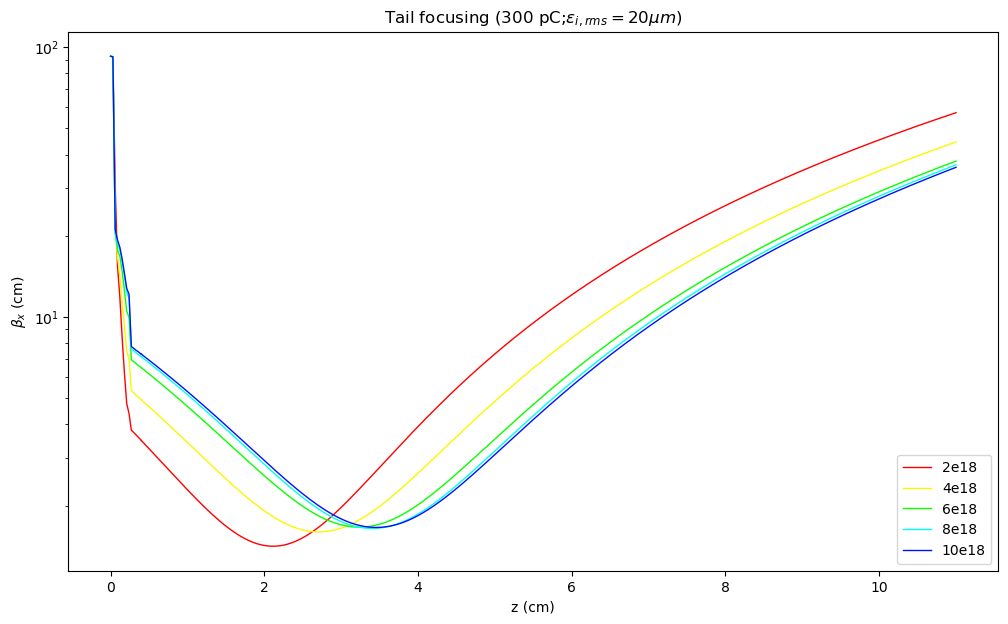

In [3]:
### select tail charge for plotting
tail = tail_2

if str(tail) == str(tail_1):
    tail_charge = t_charge1
else:
    tail_charge = t_charge2

########## vacuum propagation of beta function
def beta_prop(x,a,b,g,L):
        return b*100 - 2*(x-L)*a + (x-L)**2 * g/100
    
upp = 11
#clst = ['r','lime','grey','k','orange']
#label_lst_ne = [np.round(.5*0.28,2),np.round(0.28,2),np.round(2*0.28,2),np.round(3*0.28,2),np.round(4*0.28,2)]
#label_lst_length = np.round(np.linspace(1,3,num = 5),2)
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n+2)

cmap = get_cmap(len(data_lst))

plt.figure(figsize = (12,7))
for i in range(len(tail)):
    twiss = tail[i]

    a0 = twiss['alpha'].iloc[-1]
    b0 = twiss['beta'].iloc[-1]
    g0 = twiss['gamma'].iloc[-1]
    L0 = twiss['L'].iloc[-1]
    zf = a0/g0 + L0
    bf = b0/(1+a0**2)
    
    x = np.linspace(L0*100,upp,10**4) 
    
    plt.plot(twiss['L']*100,twiss['beta']*100,linewidth = 1,c = cmap(i),linestyle = '-')
    plt.plot(x,beta_prop(x,a0,b0,g0,L0*100),linestyle = '-', c = cmap(i),linewidth = 1,label = data_lst[i])
    #plt.axvline(x = zf*100,c = cmap(i),linestyle = 'dashdot',linewidth = 0.5)

av = twiss['alpha'].iloc[0]
bv = twiss['beta'].iloc[0]
gv = twiss['gamma'].iloc[0]
zf_v = av/gv
bf_v = bv/(1+av**2)
xv = np.linspace(0,upp,10**4) 

#plt.plot(xv,beta_prop(xv,av,bv,gv,0),linestyle = '--', c = 'k', label = 'vacuum')
#plt.axvline(x = zf_v*100,linestyle = 'dashdot', c= 'k',linewidth = 0.5)

plt.legend()    
plt.title(f'Tail focusing ({int(tail_charge/1e-12)} pC;' + r'$\epsilon_{i,rms} = 20 \mu m$)')

plt.yscale('log')
plt.xlabel('z (cm)')
plt.ylabel (r'$\beta_x$ (cm)')
plt.savefig(f'/Users/Mengshutang/desktop/{int(tail_charge/1e-12)}_20um.png',dpi = 300)

/var/folders/1_/d86r7cfn7nbb663qcn5ld6qr0000gn/T/ipykernel_60372/2661484526.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  return plt.cm.get_cmap(name, n+2)


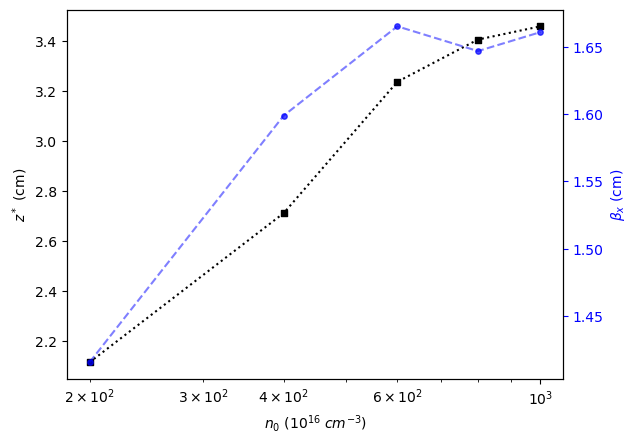

In [4]:
cmap = get_cmap(len(data_lst))

z_f_lst = []
b_f_lst = []
for i in range(len(tail)):
    twiss = tail[i]

    a0 = twiss['alpha'].iloc[-1]
    b0 = twiss['beta'].iloc[-1]
    g0 = twiss['gamma'].iloc[-1]
    L0 = twiss['L'].iloc[-1]
    zf = a0/g0 + L0
    bf = b0/(1+a0**2)
    z_f_lst.append(zf*100)
    b_f_lst.append(bf*100)

fig,ax = plt.subplots()
ax.scatter([float(_)/1e16 for _ in data_lst],z_f_lst,s = 15,marker = 's',c = 'k')
ax.plot([float(_)/1e16 for _ in data_lst],z_f_lst,linestyle = 'dotted',c = 'k')

beta = ax.twinx()
beta.scatter([float(_)/1e16 for _ in data_lst],b_f_lst, s = 15,c='b',alpha = 0.7)
beta.plot([float(_)/1e16 for _ in data_lst],b_f_lst, c = 'b',linestyle = '--',alpha = 0.5)
beta.yaxis.label.set_color('b')
beta.set_ylabel(r"$\beta_x$ (cm)")
beta.tick_params(axis='y', colors='b')

#plt.axhline(y = zf_v, c = 'b', linestyle = '--',label = 'vacuum')
ax.set_xscale('log')
ax.set_xlabel(r'$n_0$ ($10^{16}$ $cm^{-3}$)')
ax.set_ylabel(r'$z^*$ (cm)')
plt.savefig('/Users/Mengshutang/desktop/z_'+f'{int(tail_charge/1e-12)}_20um.png',dpi = 300)